# Workflows and Agents

This guide reviews common architectures for agentic systems. In describing these systems, it can be useful to make a distinction between "workflows" and "agents". Anthropic released an excellent [blog post](https://www.anthropic.com/research/building-effective-agents) on building effective agents that highlights both "agents" and "workflows":

> "Agent" can be defined in several ways. Some customers define agents as fully autonomous systems that operate independently over extended periods, using various tools to accomplish complex tasks. Others use the term to describe more prescriptive implementations that follow predefined "workflows". At Anthropic, we categorize all these variations as agentic systems.

It explains the primary difference between agents and workflows: 

> Workflows are systems where LLMs and tools are orchestrated through predefined code paths.
> Agents, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

Here is a simple way to visualize these differences:

![Agent Workflow](../concepts/img/agent_workflow.png)

## Why use a framework like LangGraph?

The blog also discusses when to consider agent frameworks. For any framework, it is important to understand the costs (or overhead) of using it versus the benefits. The blog points out that frameworks *can* add abstraction, often to promote speed or ease of use. But, this can come with costs, such as difficulty debugging or incorrect assumptions:

> (Frameworks) often create extra layers of abstraction that can obscure the underlying prompts and responses, making them harder to debug.

Our documentation [outlines](https://langchain-ai.github.io/langgraph/concepts/high_level/) the the benefits of using LangGraph: LangGraph doesn't abstract prompts or architecture. It provides supporting infrastructure for any workflow / agent, including persistence, streaming, and support for deployment.

## Building Blocks: The Augmented LLM 

LLM have [augmentations](https://www.anthropic.com/research/building-effective-agents) that support building workflows and agents. 

These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/), as shown in the blog:

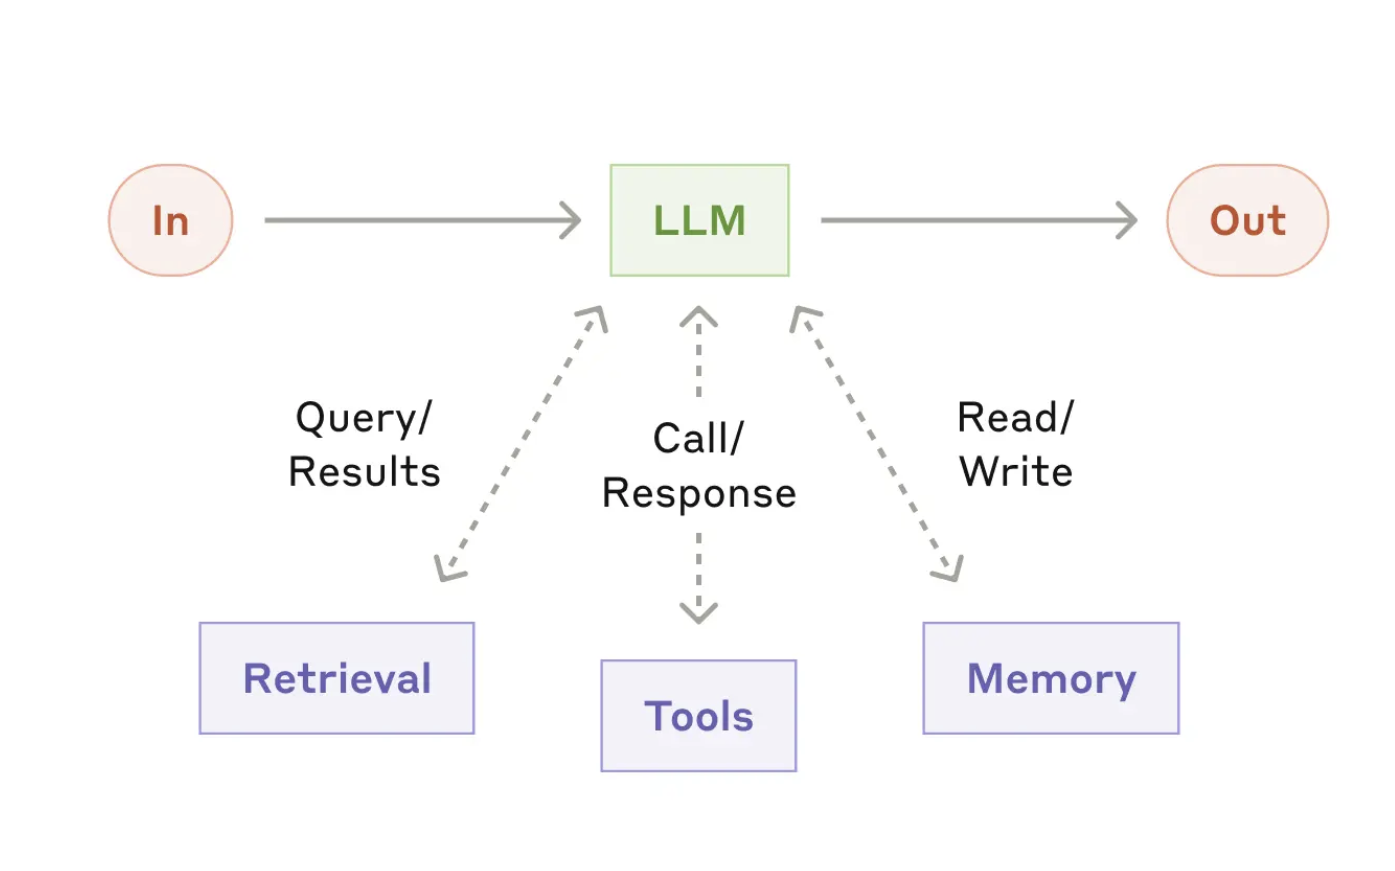

For this tutorial, you can use [any chat model](https://python.langchain.com/docs/integrations/chat/) that supports structured outputs and tool calling. Below, we show the process of installing the packages, setting API keys, and testing structured outputs / tool calling for both OpenAI and Anthropic. 

In [ ]:
! pip install langchain_core langchain-openai langchain-anthropic langgraph 

In [ ]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

In [ ]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [ ]:
from pydantic import BaseModel, Field


# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, justification="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
print(output.search_query)
print(output.justification)

In [ ]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b


# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

## Prompt chaining

In prompt chaining, each LLM call processes the output of the previous one. 

As noted in the [blog](https://www.anthropic.com/research/building-effective-agents): 

> Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

> When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

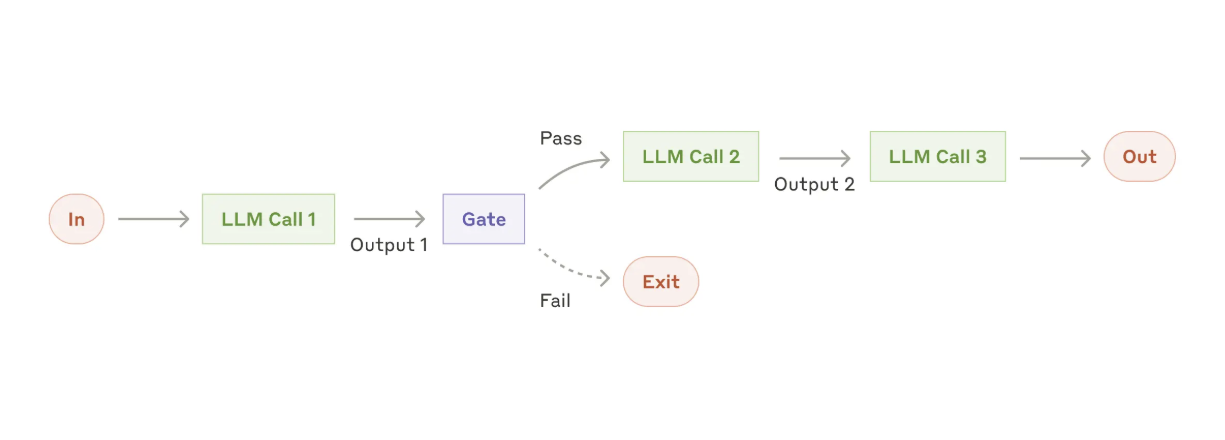

#### Resources

**LangChain Academy**
 
See our lesson on Prompt Chaining [here](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb).

#### Example Implementation

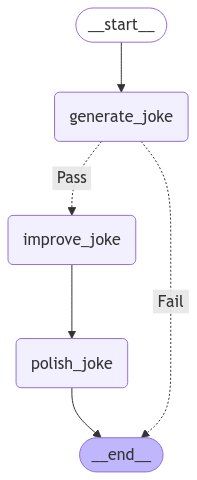

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

#### LangSmith Trace

https://smith.langchain.com/public/a0281fca-3a71-46de-beee-791468607b75/r

## Parallelization 

With parallelization, LLMs work simultaneously on a task:

>LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

> When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

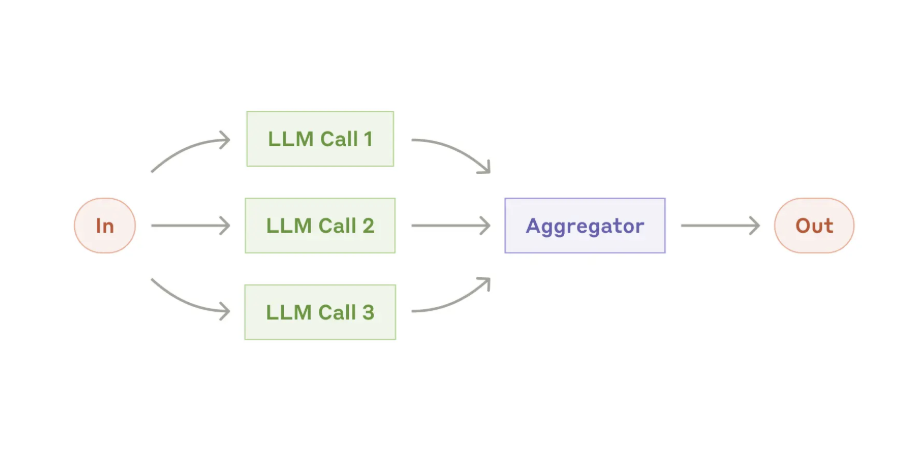

#### Resources

**Documentation**

See our documentation on parallelization [here](https://langchain-ai.github.io/langgraph/how-tos/branching/).

**LangChain Academy**
 
See our lesson on parallelization [here](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb).

#### Example Implementation

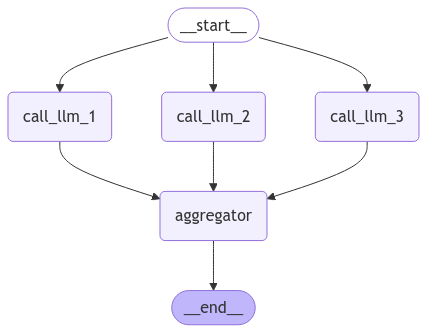

In [2]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [ ]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

#### LangSmith Trace

https://smith.langchain.com/public/3be2e53c-ca94-40dd-934f-82ff87fac277/r

## Routing 

Routing classifies an input and directs it to a specialized followup task:

> Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

> When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

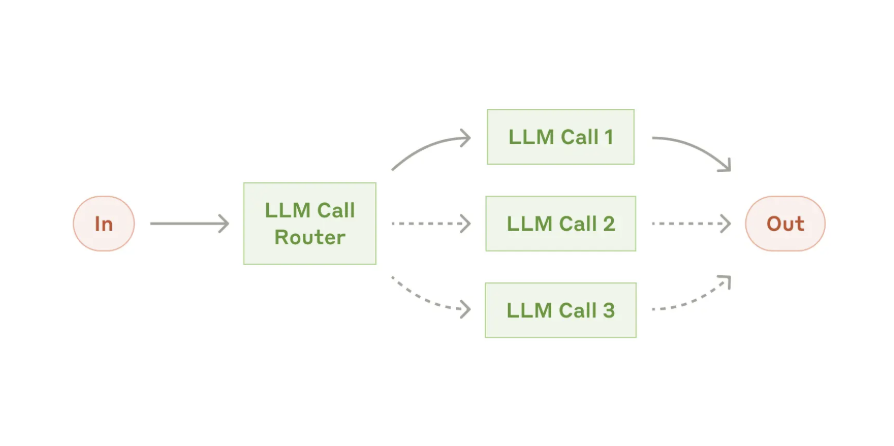

#### Resources

**LangChain Academy**

See our lesson on routing [here](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb).

**Examples**

[Here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/) is a project on RAG that utilizes routing to route questions to a vectorstore or web search. See our video [here](https://www.youtube.com/watch?v=bq1Plo2RhYI).

#### Example Implementation

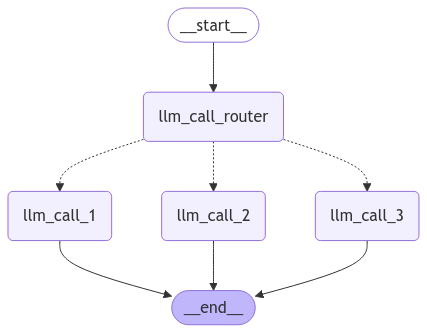

In [6]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: Route
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [ ]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

#### LangSmith Trace

https://smith.langchain.com/public/c4580b74-fe91-47e4-96fe-7fac598d509c/r

## Orchestrator-Worker 

With orchestrator-worker, an orchestrator breaks down a task and delegates each sub-task to workers: 

> In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

> When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

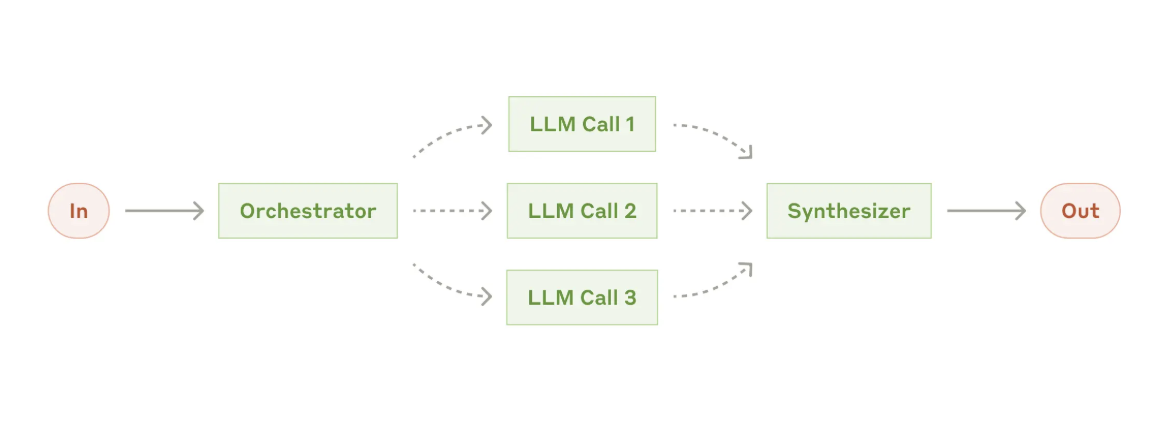

#### Resources

**LangChain Academy**

See our lesson on orchestrator-worker [here](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb).

--- 

**Examples**

[Here](https://github.com/langchain-ai/report-mAIstro) is a project that uses orchestrator-worker for report planning and writing. See our video [here](https://www.youtube.com/watch?v=wSxZ7yFbbas).

#### Example Implementation

In [9]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

#### Creating Workers in LangGraph

Because orchestrator-worker workflows are so common, LangGraph **has a specific `Send` API to support this**. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a *shared state key* that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and `Send` each to a worker node. See further documentation [here](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) and [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#send).



In [10]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

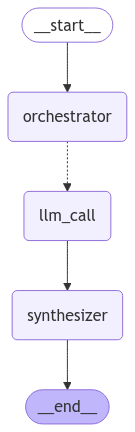

In [11]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

In [ ]:
from IPython.display import Markdown

Markdown(state["final_report"])

#### LangSmith Trace

https://smith.langchain.com/public/78cbcfc3-38bf-471d-b62a-b299b144237d/r

## Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop: 

> In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

> When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

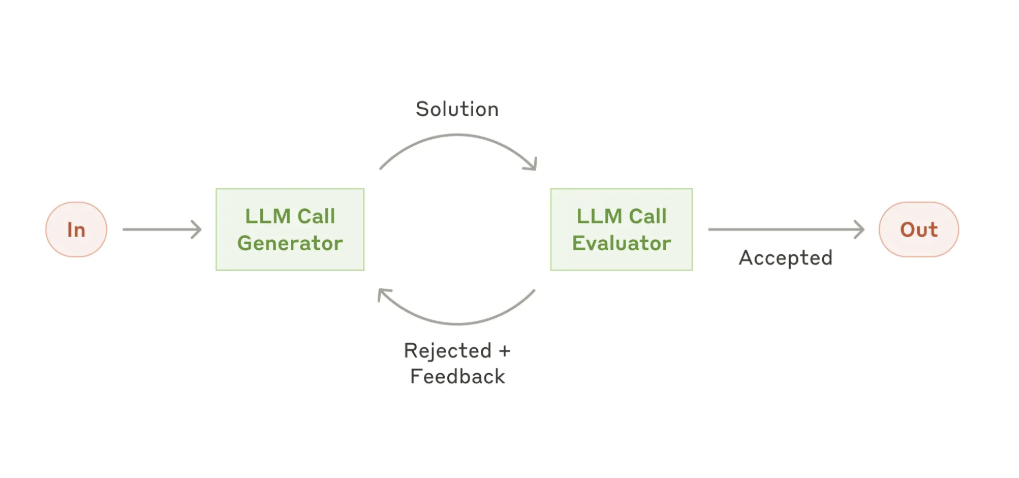

#### Resources

**Examples**

[Here](https://github.com/langchain-ai/research-rabbit) is a project that uses evaluator-optimizer to iteratively improve a report. See our video [here](https://www.youtube.com/watch?v=XGuTzHoqlj8).


[Here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/) is a project on RAG that utilizes grading to check answers for hallucinations or factual errors. See our video [here](https://www.youtube.com/watch?v=bq1Plo2RhYI).

#### Example Implementation

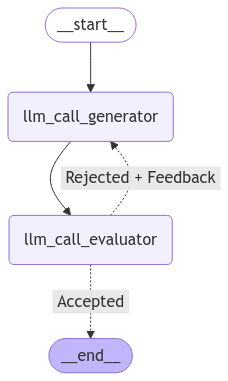

In [12]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [ ]:
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

#### LangSmith Trace

https://smith.langchain.com/public/86ab3e60-2000-4bff-b988-9b89a3269789/r

## Agent 

Agents are typically implemented as an LLM performing actions (via tool-calling) based on environmental feedback in a loop:

> Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

> When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

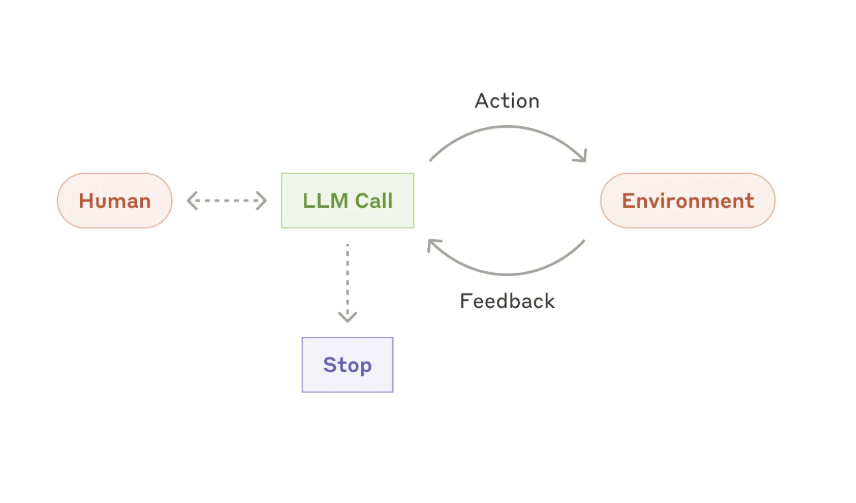

#### Resources

**LangChain Academy**

See our lesson on agents [here](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb).

**Examples**

[Here](https://github.com/langchain-ai/memory-agent) is a project that uses a tool calling agent to create / store long-term memories.

#### Example Implementation


In [13]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

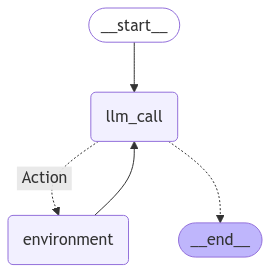

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

#### LangSmith Trace

https://smith.langchain.com/public/051f0391-6761-4f8c-a53b-22231b016690/r

#### Pre-built 

We also have a **pre-built method** for creating an agent as defined above (using the `create_react_agent` method):

https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

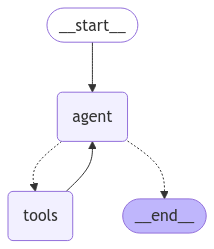

In [15]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm_with_tools, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

#### LangSmith Trace

https://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r

## What LangGraph provides

By constructing each of the above in LangGraph, we get a few things: 

### Persistence: Human-in-the-Loop

LangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See [Module 3 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/tree/main/module-3).

### Persistence: Memory 

LangGraph persistence layer supports conversational (short-term) memory and long-term memory. See [Modules 2](https://github.com/langchain-ai/langchain-academy/tree/main/module-2) [and 5](https://github.com/langchain-ai/langchain-academy/tree/main/module-5) of LangChain Academy: 

### Streaming 

LangGraph provides several ways to stream workflow / agent outputs or intermediate state. See [Module 3 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb).


### Deployment

LangGraph provides an easy on-ramp for deployment, observability, and evaluation. See [module 6](https://github.com/langchain-ai/langchain-academy/tree/main/module-6) of LangChain Academy.